In [2]:
from cirkit.templates import data_modalities, utils

symbolic_circuit = data_modalities.image_data(
    (1, 28, 28),                # The shape of MNIST image, i.e., (num_channels, image_height, image_width)
    region_graph='quad-graph',  # Select the structure of the circuit to follow the QuadGraph region graph
    input_layer='categorical',  # Use Categorical distributions for the pixel values (0-255) as input layers
    num_input_units=64,         # Each input layer consists of 64 Categorical input units
    sum_product_layer='cp',     # Use CP sum-product layers, i.e., alternate dense layers with Hadamard product layers
    num_sum_units=64,# Each dense sum layer consists of 64 sum units
    num_classes=1,
    sum_weight_param=utils.Parameterization(
        activation='softmax',   # Parameterize the sum weights by using a softmax activation
        initialization='normal' # Initialize the sum weights by sampling from a standard normal distribution
    )
)

In [3]:
# Print some information
print(f'Number of variables: {symbolic_circuit.num_variables}')
print()

# Print which structural properties the circuit satisfies
print(f'Structural properties:')
print(f'  - Smoothness: {symbolic_circuit.is_smooth}')
print(f'  - Decomposability: {symbolic_circuit.is_decomposable}')
print(f'  - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}')

Number of variables: 784

Structural properties:
  - Smoothness: True
  - Decomposability: True
  - Structured-decomposability: False


In [4]:
import random
import numpy as np
import torch

# Set some seeds
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the torch device to use
device = torch.device('cuda')

In [5]:
%%time
from cirkit.pipeline import compile
circuit = compile(symbolic_circuit)

CPU times: user 1.38 s, sys: 56.8 ms, total: 1.44 s
Wall time: 1.45 s


In [6]:
# Print some statistics
num_layers = len(list(symbolic_circuit.layers))
print(f"Number of layers: {num_layers}")
num_parameters = sum(p.numel() for p in circuit.parameters())
print(f"Number of learnable parameters: {num_parameters}")

Number of layers: 5725
Number of learnable parameters: 25657730


In [7]:
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Load the MNIST data set and data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
    # Flatten the images and set pixel values in the [0-255] range
    transforms.Lambda(lambda x: (255 * x.view(-1)).long())
])
data_train = datasets.MNIST('datasets', train=True, download=True, transform=transform)
data_test = datasets.MNIST('datasets', train=False, download=True, transform=transform)

# Instantiate the training and testing data loaders
train_dataloader = DataLoader(data_train, shuffle=True, batch_size=256)
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Initialize a torch optimizer of your choice,
#  e.g., Adam, by passing the parameters of the circuit
optimizer = optim.Adam(circuit.parameters(), lr=0.01)

In [8]:
from tqdm import tqdm

num_epochs = 10
step_idx = 0
running_loss = 0.0
running_samples = 0

# Move the circuit to chosen device
circuit = circuit.to(device)

for epoch_idx in range(num_epochs):
    # Create a tqdm progress bar for the inner loop of the current epoch
    epoch_bar = tqdm(train_dataloader, desc=f"Epoch {epoch_idx+1}/{num_epochs}")
    for i, (batch, _) in enumerate(epoch_bar):
        # The circuit expects an input of shape (batch_dim, num_variables)
        batch = batch.to(device)

        # Compute the log-likelihoods of the batch by evaluating the circuit
        log_likelihoods = circuit(batch)

        # We take the negated average log-likelihood as loss
        loss = -torch.mean(log_likelihoods)
        loss.backward()
        # Update the parameters of the circuit, as with any other model in PyTorch
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.detach() * len(batch)
        running_samples += len(batch)
        step_idx += 1

        if step_idx % 200 == 0:
            average_nll = running_loss / running_samples
            # Update the tqdm progress bar with the latest average NLL
            epoch_bar.set_postfix({"Average NLL": f"{average_nll:.3f}"})
            running_loss = 0.0
            running_samples = 0


Epoch 10/10: 100%|███████████████████████████████| 235/235 [00:08<00:00, 28.60it/s, Average NLL=683.997]


In [9]:
import numpy as np
from tqdm import tqdm

with torch.no_grad():
    test_lls = 0.0

    # Wrap the test_dataloader with tqdm progress bar
    test_bar = tqdm(test_dataloader, desc="Testing")
    for batch, _ in test_bar:
        # The circuit expects an input of shape (batch_dim, num_channels, num_variables),
        # so we unsqueeze a dimension for the channel.
        batch = batch.to(device)

        # Compute the log-likelihoods of the batch
        log_likelihoods = circuit(batch)

        # Accumulate the log-likelihoods
        test_lls += log_likelihoods.sum().item()
        
        # Update the progress bar with the current cumulative log-likelihood
        test_bar.set_postfix({"Cumulative LL": f"{test_lls:.2f}"})

    # Compute average test log-likelihood and bits per dimension
    average_ll = test_lls / len(data_test)
    bpd = -average_ll / (28 * 28 * np.log(2.0))
    print(f"Average test LL: {average_ll:.3f}")
    print(f"Bits per dimension: {bpd:.3f}")


Testing:   0%|                                         | 0/40 [00:00<?, ?it/s, Cumulative LL=-168601.06]

Testing: 100%|███████████████████████████████| 40/40 [00:01<00:00, 38.57it/s, Cumulative LL=-6823475.15]

Average test LL: -682.348
Bits per dimension: 1.256


torch.Size([1, 784])


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

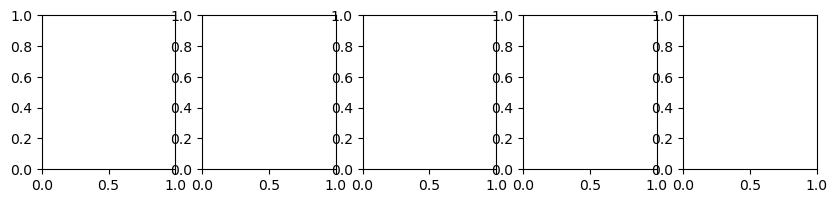

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Instantiate the test DataLoader
test_dataloader = DataLoader(data_test, shuffle=False, batch_size=256)

# Retrieve the first batch from the test DataLoader
data_iter = iter(test_dataloader)
images, labels = next(data_iter)

# Extract the first image and its label from the batch
sample_image = images[0]
sample_label = labels[0]
def generate_and_plot_images(circuit, num_images=5):
    """
    Generates and plots images from the probabilistic circuit.
    
    Args:
        circuit: The probabilistic circuit object.
        num_images: Number of images to generate.
    """
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        # Sample from the circuit
        input_data = torch.tensor(
                np.random.randint(0, 256, size=(1, 784), dtype=np.uint8),
                dtype=torch.float32  # make sure dtype is compatible with model
            )

        input_data = images[i].reshape(1,784).to(device)
        print(input_data.shape)
        sampled_data = circuit.forward(input_data).to(torch.device('cpu'))
        print(sampled_data)
        # Reshape the sampled data to 28x28 if it's flattened
        image = input_data.reshape(28, 28)
        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    plt.suptitle("Generated MNIST-like Images")
    plt.show()

# Assuming 'circuit' is your trained probabilistic circuit
generate_and_plot_images(circuit)


In [ ]:
import numpy as np
import torch

# Generate random data with values between 0 and 255, and shape (1, 28, 28)
random_data = np.random.randint(0, 256, size=(1, 28, 28), dtype=np.uint8)

# Normalize the data to the range [0, 1] if required by the model
normalized_data = random_data / 255.0

# Reshape the data to match the model's expected input shape (B, D)
reshaped_data = normalized_data.reshape(1, 784)  # 1 sample, 784 features

# Convert the NumPy array to a PyTorch tensor
input_tensor = torch.tensor(reshaped_data, dtype=torch.float32)

# Pass the tensor to the model
output = circuit.forward(input_tensor)
print(output)

In [ ]:
print(batch.shape)